In [1]:
# ============================================
# 03_modeling.ipynb — Model Training
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, RocCurveDisplay

# Create folders if missing
os.makedirs("../models", exist_ok=True)
os.makedirs("../results/metrics", exist_ok=True)

print("📌 Loading processed data...")

📌 Loading processed data...


In [2]:
# ============================================
# 1. Load processed train/test data
# ============================================

X_train = np.load("../data/processed/X_train.npy", allow_pickle=True)
X_test = np.load("../data/processed/X_test.npy", allow_pickle=True)
y_train = np.load("../data/processed/y_train.npy", allow_pickle=True)
y_test = np.load("../data/processed/y_test.npy", allow_pickle=True)

preprocessor = joblib.load("../models/preprocessor.pkl")

X_train.shape, X_test.shape

((35994, 27), (8999, 27))

In [3]:
# ============================================
# 2. Define Models
# ============================================

models = {
    "logistic_regression": LogisticRegression(max_iter=500),
    "random_forest": RandomForestClassifier(n_estimators=150),
    "xgboost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        eval_metric="logloss"
    )
}

models

{'logistic_regression': LogisticRegression(max_iter=500),
 'random_forest': RandomForestClassifier(n_estimators=150),
 'xgboost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=200, n_jobs=None,
               num_parallel_tree=None, ...)}

In [4]:
# ============================================
# 3. Train Models
# ============================================

trained_models = {}

print("📌 Training models...")

for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    joblib.dump(model, f"../models/{name}.pkl")
    print(f"Saved: ../models/{name}.pkl")

📌 Training models...
Saved: ../models/logistic_regression.pkl
Saved: ../models/random_forest.pkl
Saved: ../models/xgboost.pkl


In [5]:
# ============================================
# 4. Evaluate Models
# ============================================

def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    return {
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds),
        "recall": recall_score(y_test, preds),
        "f1": f1_score(y_test, preds),
        "roc_auc": roc_auc_score(y_test, probs)
    }

results = {}

for name, model in trained_models.items():
    results[name] = evaluate(model, X_test, y_test)

df_results = pd.DataFrame(results).T
df_results

,accuracy,precision,recall,f1,roc_auc
logistic_regression,0.898767,0.784890,0.749124,0.766590,0.956125
random_forest,0.930214,0.901466,0.769654,0.830362,0.974438
xgboost,0.934215,0.895775,0.796194,0.843054,0.978926


In [6]:
# ============================================
# 5. Save Metrics
# ============================================

df_results.to_csv("../results/metrics/model_metrics.csv", index=True)
print("Saved metrics → ../results/metrics/model_metrics.csv")

df_results

Saved metrics → ../results/metrics/model_metrics.csv


,accuracy,precision,recall,f1,roc_auc
logistic_regression,0.898767,0.784890,0.749124,0.766590,0.956125
random_forest,0.930214,0.901466,0.769654,0.830362,0.974438
xgboost,0.934215,0.895775,0.796194,0.843054,0.978926


<Figure size 800x600 with 0 Axes>

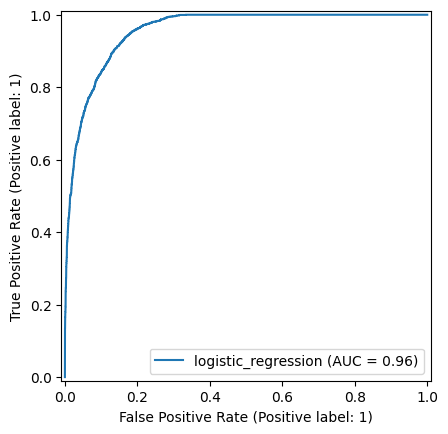

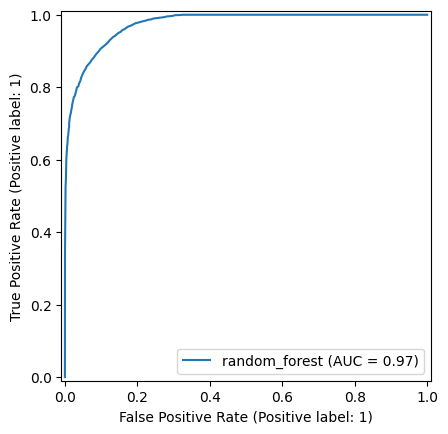

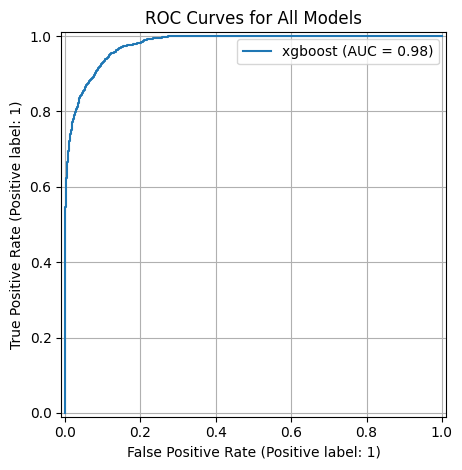

Saved ROC curves → ../results/metrics/roc_curves.png


In [7]:
# ============================================
# 6. ROC Curves — Plot & Save
# ============================================

plt.figure(figsize=(8,6))

for name, model in trained_models.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)

plt.title("ROC Curves for All Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../results/metrics/roc_curves.png")
plt.show()

print("Saved ROC curves → ../results/metrics/roc_curves.png")